In [1]:
import sys
sys.path.append("../")

from smc.sampler import SMCsampler
from smc.prior import StarPrior
from smc.images import ImageModel
from smc.kernel import MetropolisHastings
from smc.aggregate import Aggregate

import torch
# torch.cuda.is_available()
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
torch.set_default_device(device)

import matplotlib.pyplot as plt

### Generate images

We specify a prior and an image model and generate one image.

count
 6 
fluxes
 [85691.586 62518.543 62584.484 77672.12  76711.41  77430.22      0.
     0.        0.        0.        0.        0.        0.        0.
     0.        0.        0.        0.        0.        0.   ] 
locs
 [[21.835152 14.507912]
 [25.409718  9.827328]
 [ 9.703646 19.698013]
 [11.883026  8.236334]
 [22.77118  15.980642]
 [13.065156 18.441093]
 [ 0.        0.      ]
 [ 0.        0.      ]
 [ 0.        0.      ]
 [ 0.        0.      ]
 [ 0.        0.      ]
 [ 0.        0.      ]
 [ 0.        0.      ]
 [ 0.        0.      ]
 [ 0.        0.      ]
 [-0.        0.      ]
 [ 0.        0.      ]
 [ 0.        0.      ]
 [ 0.        0.      ]
 [ 0.        0.      ]] 




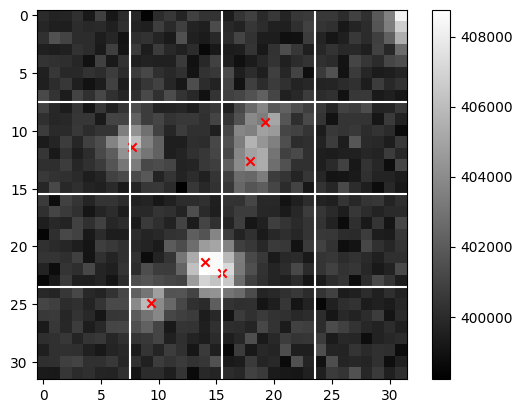

In [2]:
image_dim = 32
true_psf_stdev = 1.5
true_background = 400000
true_flux_mean = 80000
true_flux_stdev = 15000

TruePrior = StarPrior(max_objects = 20,
                      image_height = image_dim,
                      image_width = image_dim,
                      flux_mean = true_flux_mean,
                      flux_stdev = true_flux_stdev,
                      pad = 2)

TrueImageModel = ImageModel(image_height = image_dim,
                            image_width = image_dim,
                            psf_stdev = true_psf_stdev,
                            background = true_background)

true_counts, true_locs, true_fluxes, images = TrueImageModel.generate(Prior = TruePrior,
                                                                      num_images = 1)

print(f"count\n", true_counts[0].round().item(),
      "\nfluxes\n", true_fluxes[0].cpu().numpy(),
      "\nlocs\n", true_locs[0].cpu().numpy(), "\n\n")
fig, img = plt.subplots(1,1)
tmp = img.imshow(images[0].cpu(), cmap = 'gray')
_ = fig.colorbar(tmp)
_ = img.scatter(true_locs.squeeze()[:true_counts.squeeze(),1].cpu() - 0.5,
                true_locs.squeeze()[:true_counts.squeeze(),0].cpu() - 0.5, marker = 'x', color = 'red')
_ = img.vlines(x = image_dim//4 - 0.5, ymin = 0 - 0.5, ymax = image_dim - 0.5, color = 'white')
_ = img.vlines(x = 2*image_dim//4 - 0.5, ymin = 0 - 0.5, ymax = image_dim - 0.5, color = 'white')
_ = img.vlines(x = 3*image_dim//4 - 0.5, ymin = 0 - 0.5, ymax = image_dim - 0.5, color = 'white')
_ = img.hlines(y = image_dim//4 - 0.5, xmin = 0 - 0.5, xmax = image_dim - 0.5, color = 'white')
_ = img.hlines(y = 2*image_dim//4 - 0.5, xmin = 0 - 0.5, xmax = image_dim - 0.5, color = 'white')
_ = img.hlines(y = 3*image_dim//4 - 0.5, xmin = 0 - 0.5, xmax = image_dim - 0.5, color = 'white')

### Perform inference with SMC

We set the side length of the tiles on which we will run the sampler, and we specify a prior and image model at the tile level. We also specify a mutation kernel to be used within the SMC sampler.

We'll assume that the image background, PSF standard deviation, and flux prior parameters are all known.

In [3]:
tile_dim = 8

TilePrior = StarPrior(max_objects = 4,
                      image_height = tile_dim,
                      image_width = tile_dim,
                      flux_mean = true_flux_mean,
                      flux_stdev = true_flux_stdev,
                      pad = 2)

TileImageModel = ImageModel(image_height = tile_dim,
                            image_width = tile_dim,
                            psf_stdev = true_psf_stdev,
                            background = true_background)

MHKernel = MetropolisHastings(num_iters = 75,
                              locs_stdev = 0.1,
                              features_stdev = 1000,
                              features_min = 50000,
                              features_max = 110000)

Now we initialize an `SMCsampler` object and run it on the tiles.

In [4]:
smc = SMCsampler(image = images[0],
                 tile_dim = tile_dim,
                 Prior = TilePrior,
                 ImageModel = TileImageModel,
                 MutationKernel = MHKernel,
                 num_catalogs_per_count = 1000,
                 max_smc_iters = 100)

print(f"True count: {true_counts[0]}")
print(f"True total flux: {true_fluxes[0].sum()}\n")

smc.run(print_progress = True)

True count: 6
True total flux: 442608.34375

Starting the tile samplers...
iteration 5, temperature = 0.01261165551841259
iteration 10, temperature = 0.06180683523416519
iteration 15, temperature = 0.22040070593357086
iteration 20, temperature = 0.7092032432556152
Done!



Now we instantiate an `Aggregate` object with the tile-level results from above:

In [5]:
agg = Aggregate(smc.Prior,
                smc.ImageModel,
                smc.tiled_image,
                smc.counts,
                smc.locs,
                smc.features,
                smc.weights_intercount)

We run the aggregation procedure to obtain image-level catalogs:

In [6]:
agg.run()

We compute the posterior mean number of light sources:

In [7]:
agg.posterior_mean_counts

tensor([[6.]], device='cuda:4')

And we compute the posterior mean total flux:

In [8]:
agg.posterior_mean_total_flux

tensor([[438847.6875]], device='cuda:4')

Finally, we reconstruct the image using one of the catalogs we just sampled:

tensor([[[22.5026, 14.7199],
         [21.5070, 15.5242],
         [25.2776,  9.8120],
         [ 9.8894, 19.5848],
         [13.0158, 18.6874],
         [11.7124,  8.2349],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [-0.0000, -0.0000],
         [ 0.0000,  0.0000],
         [-0.0000,  0.0000]]], device='cuda:4')
tensor([[94070.0547, 55799.0156, 70783.0469, 62449.2070, 69455.6875, 86289.2344,
             0.0000,     0.0000,     0.0000,     0.0000,     0.0000]],
       device='cuda:4')


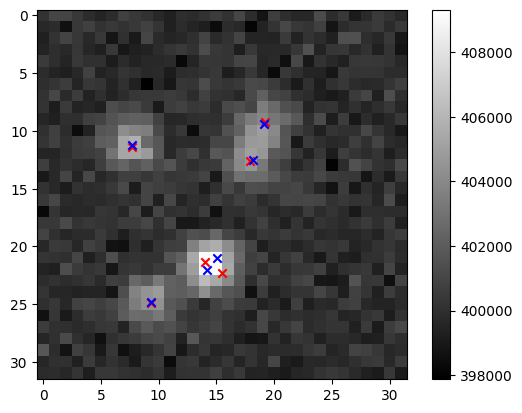

In [9]:
index = torch.randint(low = 0, high = agg.counts.shape[-1] - 1, size = [1])
print(agg.locs.squeeze()[index])
print(agg.features.squeeze()[index])
psf = agg.ImageModel.psf(agg.locs[:,:,index])
rate = (psf * agg.features[:,:,index].unsqueeze(-3).unsqueeze(-4)).sum(-1) + agg.ImageModel.background
reconstruction = torch.distributions.Poisson(rate).sample().squeeze([0,1]).permute((2,0,1))
_ = plt.imshow(reconstruction[0].cpu(), cmap = 'gray')
_ = plt.colorbar()
_ = plt.scatter(true_locs.squeeze()[:true_counts.squeeze(),1].cpu() - 0.5,
                true_locs.squeeze()[:true_counts.squeeze(),0].cpu() - 0.5, marker = 'x', color = 'red')
_ = plt.scatter(agg.locs.squeeze()[index,:agg.counts.squeeze()[index],1].cpu() - 0.5,
                agg.locs.squeeze()[index,:agg.counts.squeeze()[index],0].cpu() - 0.5, marker = 'x', color = 'blue')